# Import dataset

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gp
import geopandas as gpd
import numpy as np

In [3]:
data1 = pd.read_csv('1.csv', dtype={'tenant': str})
data2 = pd.read_csv('2.csv', dtype={'tenant': str})
data3 = pd.read_csv('3.csv', dtype={'tenant': str})
data4 = pd.read_csv('4.csv', dtype={'tenant': str})
data5 = pd.read_csv('5.csv', dtype={'tenant': str})
# if not set dtype={'tenant': str}. then I'll get: 
# DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.

In [4]:
merged = pd.concat([data1,data2,data3,data4,data5])
merged = merged[['datetime', 'site_latitude', 'site_longitude', 'site_name', 'pm2_5_calibrated_value']]

merged.shape

(940254, 5)

# Add environmental variables

In [5]:
merged['datetime'] = pd.to_datetime(merged['datetime']) 
merged = merged.sort_values(by='datetime')


merged['hour'] = merged['datetime'].dt.hour
merged['day'] = merged['datetime'].dt.day
merged['month'] = merged['datetime'].dt.month
merged['year'] = merged['datetime'].dt.year

In [6]:
# Check Data Type again -- Correct
for column in merged.columns:
    data_type = merged[column].dtype
    print(f"{column}: {data_type}")

datetime: datetime64[ns]
site_latitude: float64
site_longitude: float64
site_name: object
pm2_5_calibrated_value: float64
hour: int32
day: int32
month: int32
year: int32


In [7]:
from glob import glob

# Load and prepare initial data
# Ensure merged is already loaded with correct data types and column names
# Example: merged = pd.read_csv('initial_data.csv')

# Read all result files and merge
files = glob("site_*_results.csv")
results_list = [pd.read_csv(file) for file in files]
all_results = pd.concat(results_list, ignore_index=True)

# Convert data types
all_results[['YEAR', 'MO', 'DY', 'HR']] = all_results[['YEAR', 'MO', 'DY', 'HR']].astype(int)
merged[['year', 'month', 'day', 'hour']] = merged[['year', 'month', 'day', 'hour']].astype(int)

# Rename columns to match
all_results.rename(columns={
    'YEAR': 'year', 
    'MO': 'month', 
    'DY': 'day', 
    'HR': 'hour',
    'LON': 'site_longitude', 
    'LAT': 'site_latitude'
}, inplace=True)

# Convert longitude and latitude to numeric
all_results['site_longitude'] = pd.to_numeric(all_results['site_longitude'], errors='coerce')
all_results['site_latitude'] = pd.to_numeric(all_results['site_latitude'], errors='coerce')

# Merge datasets
merged = pd.merge(merged, all_results, how='left', on=['site_longitude', 'site_latitude', 'year', 'month', 'day', 'hour'])

# Select desired columns
desired_columns = ['datetime', 'site_latitude', 'site_longitude', 'site_name', 'year', 'month', 'day', 'hour', 'RH2M', 'T2M', 'PRECTOTCORR', 'pm2_5_calibrated_value']
merged = merged[desired_columns]
merged = merged.drop(columns=['year', 'month', 'day', 'hour'])
# Print to verify
print(merged.head())


             datetime  site_latitude  site_longitude  \
0 2022-01-01 01:00:00       0.290822       32.553698   
1 2022-01-01 01:00:00       0.313128       32.582862   
2 2022-01-01 01:00:00       0.284617       32.588796   
3 2022-01-01 01:00:00       0.313128       32.582862   
4 2022-01-01 01:00:00       0.325158       32.552697   

                   site_name   RH2M    T2M  PRECTOTCORR  \
0            Rubaga, Kampala  87.81  18.75         0.04   
1             KampalaCentral  87.81  18.75         0.04   
2  Makindye, Lukuli Makindye  87.81  18.75         0.04   
3             KampalaCentral  87.81  18.75         0.04   
4                     Rubaga  87.81  18.75         0.04   

   pm2_5_calibrated_value  
0                   11.87  
1                   32.44  
2                   14.91  
3                   32.44  
4                   30.59  


In [8]:
# Change Data Type
merged['datetime'] = pd.to_datetime(merged['datetime'], dayfirst=False, utc=True)  # Ensure the datetime is in UTC
merged['site_name'] = merged['site_name'].astype('string')
print(merged['datetime'].head())
# Convert 'datetime' from UTC to EAT (East Africa Time, UTC+3)
merged['datetime'] = merged['datetime'].dt.tz_convert('Africa/Nairobi')  # Convert to EAT
print(merged['datetime'].head())

0   2022-01-01 01:00:00+00:00
1   2022-01-01 01:00:00+00:00
2   2022-01-01 01:00:00+00:00
3   2022-01-01 01:00:00+00:00
4   2022-01-01 01:00:00+00:00
Name: datetime, dtype: datetime64[ns, UTC]
0   2022-01-01 04:00:00+03:00
1   2022-01-01 04:00:00+03:00
2   2022-01-01 04:00:00+03:00
3   2022-01-01 04:00:00+03:00
4   2022-01-01 04:00:00+03:00
Name: datetime, dtype: datetime64[ns, Africa/Nairobi]


In [9]:
# Check Data Type again -- Correct
for column in merged.columns:
    data_type = merged[column].dtype
    print(f"{column}: {data_type}")

datetime: datetime64[ns, Africa/Nairobi]
site_latitude: float64
site_longitude: float64
site_name: string
RH2M: float64
T2M: float64
PRECTOTCORR: float64
pm2_5_calibrated_value: float64


## Check missing values：nan, 0

In [10]:
print(f"Number of data: {merged.shape[0]}")

#Count the number of NaN
nan_count = merged.isna().sum().sum()

#Count the number of 0
zero_count = (merged == 0).sum().sum()

print(f"Number of NaN: {nan_count}")
print(f"Number of 0: {zero_count}")

#Drop rows containing NaN
merged = merged.dropna()

#Drop rows containing 0
merged = merged.replace(0, np.nan).dropna()

# Output after processing
print(f"Number of data after processing: {merged.shape[0]}")


Number of data: 940254
Number of NaN: 148351
Number of 0: 307013
Number of data after processing: 535115


## Multiple latitudes and longitudes for the same site name: Yes

In [11]:
unique_latitudes = merged.groupby('site_name')['site_latitude'].nunique()
unique_longitudes = merged.groupby('site_name')['site_longitude'].nunique()
inconsistent_locations = (unique_latitudes > 1) | (unique_longitudes > 1)

if inconsistent_locations.any():
    print("There are cases where site names correspond to multiple locations.")
    print("Site names and their corresponding unique latitudes and longitudes numbers:\n", pd.concat([unique_latitudes, unique_longitudes], axis=1)[inconsistent_locations])
else:
    print("All site names correspond to unique locations.")


There are cases where site names correspond to multiple locations.
Site names and their corresponding unique latitudes and longitudes numbers:
                       site_latitude  site_longitude
site_name                                          
KampalaCentral                    5               5
Kawempe                           4               4
Makindye                          4               4
Nakasero II, Kampala              2               2
Rubaga                            3               3


## Existence of duplicates: yes

In [13]:
duplicates = merged.duplicated(subset=['datetime', 'site_latitude', 'site_longitude', 'site_name', 'pm2_5_calibrated_value'], keep=False)
if duplicates.any():
    print("Number of duplicates:", duplicates.sum())
#Delete duplicates, keeping only the first record in each group of duplicates
merged_unique = merged.drop_duplicates(subset=['datetime', 'site_latitude', 'site_longitude', 'site_name', 'pm2_5_calibrated_value'])
print("Number of data after deleting:", merged_unique.shape[0])


Number of duplicates: 495476
Number of data after deleting: 212647


## Same time and place corresponding to different pm2.5 values: yes

In [14]:
duplicate_rows = merged_unique[merged_unique.duplicated(subset=['datetime', 'site_latitude', 'site_longitude', 'site_name'], keep=False)]
grouped = duplicate_rows.groupby(['datetime', 'site_latitude', 'site_longitude', 'site_name'])
filtered_groups = grouped.filter(lambda x: x['pm2_5_calibrated_value'].nunique() > 1)
sorted_filtered_groups = filtered_groups.sort_values(by=['datetime', 'site_name'])
print(sorted_filtered_groups.head())


                    datetime  site_latitude  site_longitude  \
1  2022-01-01 04:00:00+03:00       0.313128       32.582862   
5  2022-01-01 04:00:00+03:00       0.313128       32.582862   
18 2022-01-01 04:00:00+03:00       0.329496       32.570619   
37 2022-01-01 04:00:00+03:00       0.329496       32.570619   
7  2022-01-01 04:00:00+03:00       0.337095       32.610288   

                              site_name   RH2M    T2M  PRECTOTCORR  \
1                        KampalaCentral  87.81  18.75         0.04   
5                        KampalaCentral  87.81  18.75         0.04   
18  Makerere University Weather Station  87.81  18.75         0.04   
37  Makerere University Weather Station  87.81  18.75         0.04   
7              Nakawa, KCCA Head Office  87.81  18.75         0.04   

    pm2_5_calibrated_value  
1                    32.44  
5                    19.77  
18                   23.20  
37                   12.70  
7                    18.02  


## Calculation of the mean value of different pm2.5 corresponding to the same time location

In [17]:
merged_unique = merged_unique.groupby(['datetime', 'site_latitude', 'site_longitude', 'site_name'], as_index=False).agg({
    'pm2_5_calibrated_value': 'mean',
    'RH2M': 'first',
    'T2M': 'first',
    'PRECTOTCORR': 'first'
})




## Outliers replaced by mean

In [15]:
def replace_outliers(group):
    q1 = group['pm2_5_calibrated_value'].quantile(0.25)
    q3 = group['pm2_5_calibrated_value'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Calculate the average of the removed outliers
    mean_value = group[(group['pm2_5_calibrated_value'] >= lower_bound) & 
                       (group['pm2_5_calibrated_value'] <= upper_bound)]['pm2_5_calibrated_value'].mean()
    
    group['pm2_5_calibrated_value'] = np.where((group['pm2_5_calibrated_value'] < lower_bound) | 
                                               (group['pm2_5_calibrated_value'] > upper_bound),
                                               mean_value, group['pm2_5_calibrated_value'])
    return group
merged_unique = merged_unique.groupby('site_name').apply(replace_outliers)
merged_unique = merged_unique.reset_index(drop=True)


C:\Users\DELL\AppData\Local\Temp\ipykernel_76684\1020634836.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_unique = merged_unique.groupby('site_name').apply(replace_outliers)


# Visualization: Time Series Analysis

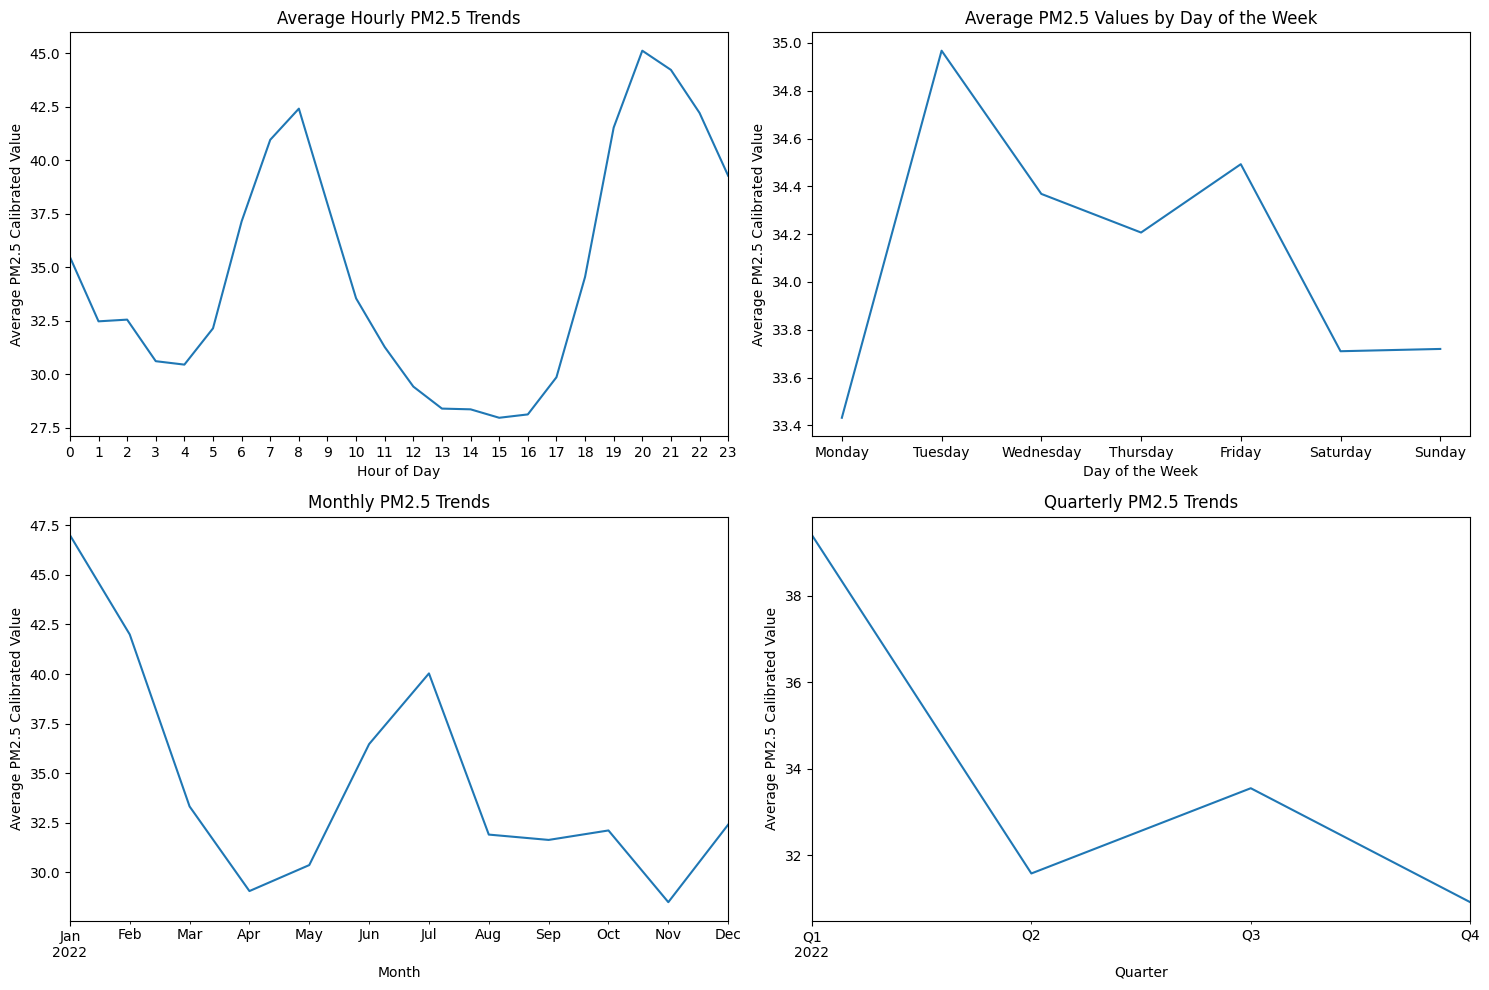

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming merged_unique is already defined and contains the required data
plotting_data = merged_unique.copy()

plotting_data['datetime'] = pd.to_datetime(plotting_data['datetime'])
plotting_data.set_index('datetime', inplace=True)

# Hourly
plotting_data['hour'] = plotting_data.index.hour
hourly_avg_pm25 = plotting_data.groupby('hour')['pm2_5_calibrated_value'].mean()

# Weekly
plotting_data['weekday'] = plotting_data.index.weekday #weekday:0-Mon, 6-Sun
weekly_avg_pm25 = plotting_data.groupby('weekday')['pm2_5_calibrated_value'].mean()
weekly_avg_pm25.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Monthly
monthly_pm25 = plotting_data['pm2_5_calibrated_value'].resample('ME').mean()

# Quarterly
quarterly_pm25 = plotting_data['pm2_5_calibrated_value'].resample('QE').mean()

# Creating subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plotting Hourly
hourly_avg_pm25.plot(ax=axs[0, 0], title='Average Hourly PM2.5 Trends')
axs[0, 0].set_ylabel('Average PM2.5 Calibrated Value')
axs[0, 0].set_xlabel('Hour of Day')
axs[0, 0].set_xticks(range(0, 24))
axs[0, 0].set_xlim(0, 23)

# Plotting Weekly
weekly_avg_pm25.plot(kind='line', ax=axs[0, 1], title='Average PM2.5 Values by Day of the Week')
axs[0, 1].set_ylabel('Average PM2.5 Calibrated Value')
axs[0, 1].set_xlabel('Day of the Week')

# Plotting Monthly
monthly_pm25.plot(ax=axs[1, 0], title='Monthly PM2.5 Trends')
axs[1, 0].set_ylabel('Average PM2.5 Calibrated Value')
axs[1, 0].set_xlabel('Month')

# Plotting Quarterly
quarterly_pm25.plot(ax=axs[1, 1], title='Quarterly PM2.5 Trends')
axs[1, 1].set_ylabel('Average PM2.5 Calibrated Value')
axs[1, 1].set_xlabel('Quarter')

# Adjust layout
plt.tight_layout()
plt.show()


## Feature engineering

In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

data = merged_unique

# Grid
lat_grid_size = 0.001  
long_grid_size = 0.001  

data['lat_grid'] = np.floor(data['site_latitude'] / lat_grid_size).astype(int)
data['long_grid'] = np.floor(data['site_longitude'] / long_grid_size).astype(int)

grid_stats = data.groupby(['lat_grid', 'long_grid'])['pm2_5_calibrated_value'].agg(['mean', 'median', 'max', 'min']).reset_index()
grid_stats.rename(columns={'mean': 'grid_mean', 'median': 'grid_median', 'max': 'grid_max', 'min': 'grid_min'}, inplace=True)
data = pd.merge(data, grid_stats, on=['lat_grid', 'long_grid'], how='left')


data['datetime'] = pd.to_datetime(data['datetime']) 
data = data.sort_values(by='datetime')

# time
data['hour'] = data['datetime'].dt.hour
data['day'] = data['datetime'].dt.day
data['weekday'] = data['datetime'].dt.weekday  # from 0 to 6 (Monday to Saturday)
data['month'] = data['datetime'].dt.month
data['year'] = data['datetime'].dt.year

features_columns = ['hour', 'day', 'weekday', 'month', 'year', 'site_latitude', 'site_longitude', 'lat_grid', 'long_grid', 'grid_mean', 'grid_median', 'RH2M', 'T2M', 'PRECTOTCORR']
target_column = 'pm2_5_calibrated_value'



# Interactive features
data['lat_hour'] = data['lat_grid'] * data['hour']
data['long_hour'] = data['long_grid'] * data['hour']
data['temp_rh'] = data['T2M'] * data['RH2M']
data['precip_hour'] = data['PRECTOTCORR'] * data['hour']


# Polynomial features
data['T2M_squared'] = data['T2M'] ** 2
data['RH2M_squared'] = data['RH2M'] ** 2

# Abnormal Weather Conditions Marker
data['high_temp'] = (data['T2M'] > 30).astype(int)
data['low_temp'] = (data['T2M'] < 0).astype(int)
data['high_rh'] = (data['RH2M'] > 80).astype(int)
data['low_rh'] = (data['RH2M'] < 30).astype(int)

data.set_index('datetime', inplace=True)


# Features columns
features_columns = [
    'hour', 'day', 'weekday', 'month', 'year', 'site_latitude', 'site_longitude',
    'lat_grid', 'long_grid', 'grid_mean', 'grid_median', 'RH2M', 'T2M', 'PRECTOTCORR',
    'temp_rh', 'precip_hour', 'lat_hour', 'long_hour',
    'T2M_squared', 'RH2M_squared', 'high_temp', 'low_temp', 'high_rh', 'low_rh'
]




## Correlation Heatmap

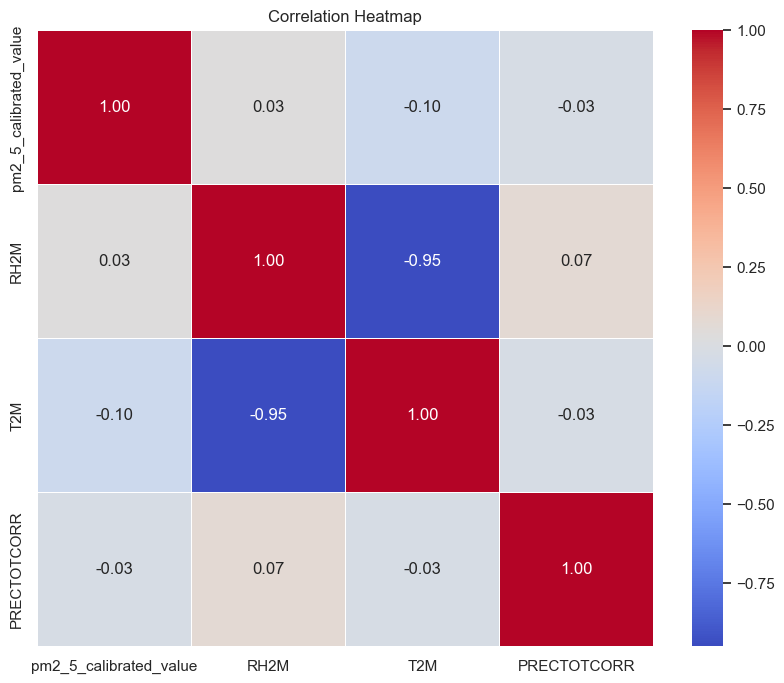

In [26]:
selected_columns = plotting_data[['pm2_5_calibrated_value', 'RH2M', 'T2M', 'PRECTOTCORR']]
corr_matrix = selected_columns.corr()
sns.set(style='white')
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True, linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

## Map with 4 groups based on the mean pm2_5_calibrated_value of the site

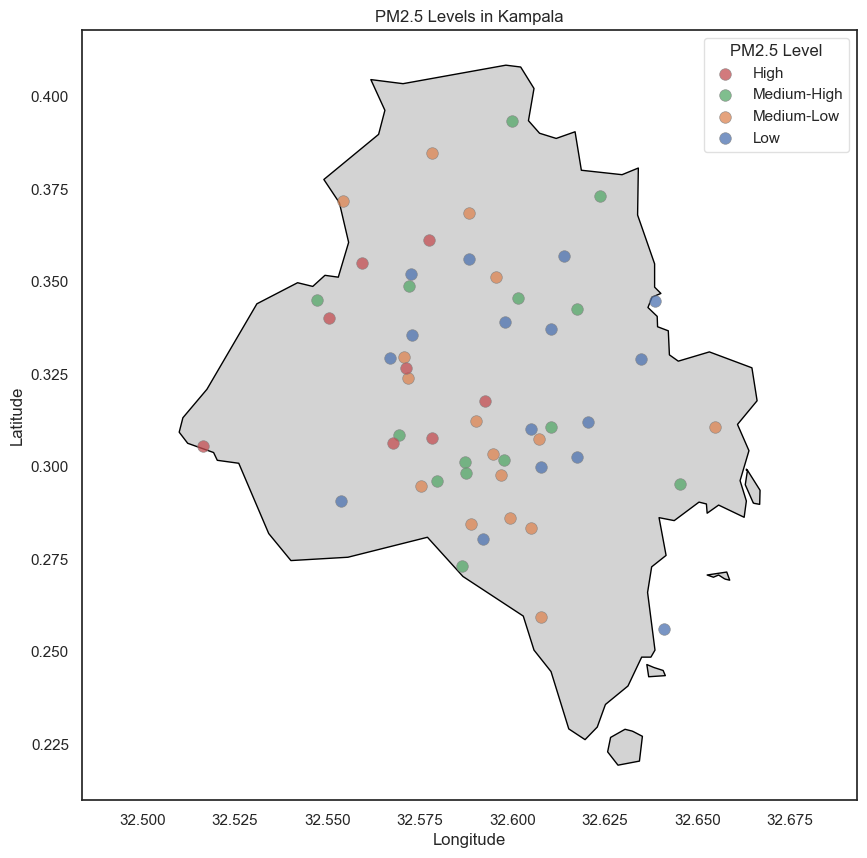

In [27]:
# Split into four groups based on the mean pm2_5_calibrated_value of the site
site_avg_pm25 = plotting_data.groupby('site_name')['pm2_5_calibrated_value'].transform('mean')
plotting_data['pm2_5_calibrated_value_avg'] = site_avg_pm25

# quantile
q1 = plotting_data['pm2_5_calibrated_value_avg'].quantile(0.25)
q2 = plotting_data['pm2_5_calibrated_value_avg'].quantile(0.50)
q3 = plotting_data['pm2_5_calibrated_value_avg'].quantile(0.75)

conditions = [
    (plotting_data['pm2_5_calibrated_value_avg'] <= q1),
    (plotting_data['pm2_5_calibrated_value_avg'] > q1) & (plotting_data['pm2_5_calibrated_value_avg'] <= q2),
    (plotting_data['pm2_5_calibrated_value_avg'] > q2) & (plotting_data['pm2_5_calibrated_value_avg'] <= q3),
    (plotting_data['pm2_5_calibrated_value_avg'] > q3)
]
choices = ['Low', 'Medium-Low', 'Medium-High', 'High']
plotting_data['pm2_5_level'] = np.select(conditions, choices, default='High')

# GeoDataFrame
gdf = gpd.GeoDataFrame(plotting_data, geometry=gpd.points_from_xy(plotting_data.site_longitude,plotting_data.site_latitude))

gdf = gdf.drop_duplicates(subset='site_name', keep='last')

shp = gpd.read_file('gadm41_UGA_1.json')
shp_kampala = shp[shp['NAME_1'] == 'Kampala']

fig, ax = plt.subplots(figsize=(10, 10))
shp_kampala.plot(ax=ax, color='lightgray', edgecolor='black')

for level in choices:
    level_gdf = gdf[gdf['pm2_5_level'] == level]
    ax.scatter(level_gdf.geometry.x, level_gdf.geometry.y, s=70, label=level,
    alpha=0.75, edgecolors='gray', linewidth=0.5)

ax.grid(False)

ax.set_title('PM2.5 Levels in Kampala')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.axis('equal')


handles, labels = ax.get_legend_handles_labels()
order = ['High', 'Medium-High', 'Medium-Low', 'Low']
ordered_handles = [handles[labels.index(l)] for l in order]
ax.legend(ordered_handles, order, title='PM2.5 Level', loc='upper right', frameon=True, framealpha=0.6)

plt.show()

## Boxplot

<Figure size 1000x600 with 0 Axes>

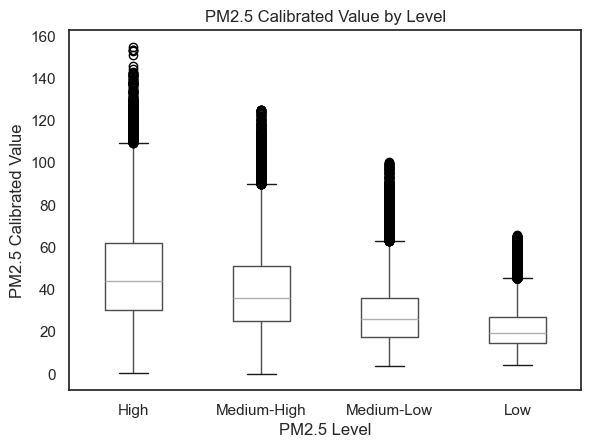

In [28]:
# boxplot for each level

plotting_data['pm2_5_level'] = pd.Categorical(plotting_data['pm2_5_level'],
                                              categories=['High', 'Medium-High', 'Medium-Low', 'Low'],
                                              ordered=True)

plt.figure(figsize=(10, 6))
plotting_data.boxplot(column='pm2_5_calibrated_value', by='pm2_5_level', grid=False)

plt.title('PM2.5 Calibrated Value by Level')
plt.suptitle('')
plt.xlabel('PM2.5 Level')
plt.ylabel('PM2.5 Calibrated Value')

plt.show()

